# How to Explain Black-Box Machine Learning Models

## 1) Install Libraries

In [1]:
!pip install folktables catboost imodels interpret shap

Defaulting to user installation because normal site-packages is not writeable
INFO: pip is looking at multiple versions of interpret-core to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of interpret-core to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 133.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of mlxtend to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 14.5 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━

## 2) Load Libraries

In [60]:
import math
import os
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=DeprecationWarning)

#DATA WRANGLING
import numpy as np
import pandas as pd
from folktables import ACSDataSource, ACSEmployment
from sklearn.model_selection import train_test_split

#MODELING
from tqdm.notebook import trange, tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics, linear_model, tree, ensemble, neural_network
import catboost as cb
from imodels import FIGSClassifier
from interpret.glassbox import ExplainableBoostingClassifier

#VISUALIZATION & INTERPRETATION
import matplotlib.pyplot as plt
import seaborn as sns
import shap

## 3) Data Understanding & Preparations

### 3.1) Load Dataset

These two lines will grab the Census data for one year and then subset the data for one state.

In [3]:
data_source = ACSDataSource(survey_year='2017', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=["NC"], 
                                download=True)

If we take a sample of this dataset we realize it returns hundreds of variables:

In [4]:
acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,CIT,CITWP,COW,DDRS,DEAR,DEYE,DOUT,DPHY,DRAT,DRATX,DREM,ENG,FER,GCL,GCM,GCR,HINS1,HINS2,HINS3,HINS4,HINS5,HINS6,HINS7,INTP,JWMNP,JWRIP,JWTR,LANX,MAR,MARHD,...,PWGTP41,PWGTP42,PWGTP43,PWGTP44,PWGTP45,PWGTP46,PWGTP47,PWGTP48,PWGTP49,PWGTP50,PWGTP51,PWGTP52,PWGTP53,PWGTP54,PWGTP55,PWGTP56,PWGTP57,PWGTP58,PWGTP59,PWGTP60,PWGTP61,PWGTP62,PWGTP63,PWGTP64,PWGTP65,PWGTP66,PWGTP67,PWGTP68,PWGTP69,PWGTP70,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2017000000033,5,1,400,3,37,1011189,12,38,1,NaN,1.0,2.0,2,2,2.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1,2,2,2,2,2,2,0.0,30.0,1.0,1.0,2.0,1,2.0,...,5,10,15,18,23,5,5,21,14,4,21,16,10,16,4,15,13,9,15,16,3,10,17,26,37,5,3,21,13,4,17,32,13,14,4,12,18,11,15,17
1,P,2017000000033,5,2,400,3,37,1011189,18,34,1,NaN,1.0,2.0,1,2,2.0,2.0,NaN,NaN,2.0,NaN,2.0,2.0,NaN,NaN,1,2,2,2,2,2,2,0.0,45.0,1.0,1.0,2.0,1,2.0,...,9,23,25,30,31,5,5,33,19,5,27,30,21,19,6,13,17,21,21,28,8,18,22,43,42,6,4,24,23,6,30,35,21,15,7,24,20,23,19,21
2,P,2017000000033,5,3,400,3,37,1011189,10,17,1,NaN,1.0,2.0,2,2,2.0,2.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,1,2,2,2,2,2,2,0.0,20.0,2.0,1.0,2.0,5,NaN,...,5,12,13,17,21,3,3,24,9,4,21,16,10,9,2,10,7,8,9,12,3,8,9,21,27,4,2,18,12,2,15,23,9,12,4,8,14,9,9,11
3,P,2017000000033,5,4,400,3,37,1011189,11,15,1,NaN,NaN,2.0,2,2,2.0,2.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,1,2,2,2,2,2,2,0.0,NaN,NaN,NaN,2.0,5,NaN,...,4,13,12,16,22,3,4,24,9,4,21,14,11,10,4,8,8,7,9,13,2,6,10,21,26,4,1,16,10,2,15,22,8,12,4,8,14,8,10,10
4,P,2017000000033,5,5,400,3,37,1011189,14,11,1,NaN,NaN,2.0,2,2,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1,2,2,2,2,2,2,NaN,NaN,NaN,NaN,2.0,5,NaN,...,3,19,19,22,29,7,7,28,12,5,22,24,21,21,4,18,15,10,15,23,5,15,21,26,36,5,4,22,16,4,23,23,13,13,5,12,21,13,11,12


### 3.2) Preprocess Steps

There are a few quick preprocessing steps we will need to do since we are only interested in certain features and individuals at least 16 years old. We will also convert a few categorical variables to binary format and turn our categorical target (`ESR`) into binary as well.

In [5]:
#Subset and preprocess the variables, and fill NaN values with 0
employment_df = ACSEmployment \
                ._preprocess(acs_data) \
                [ACSEmployment.features + [ACSEmployment.target]] \
                .fillna(0) \
                .astype(int)

In [8]:
#Subset to only those over or equal to the age of 16 
employment_df = employment_df[employment_df.AGEP >= 16]

In [9]:
#Encode several variables that only have two categories as binary
employment_df['DIS'] = np.where(employment_df.DIS == 1, 1, 0)
employment_df['NATIVITY'] = np.where(employment_df.NATIVITY == 1, 1, 0)
employment_df['DEAR'] = np.where(employment_df.DEAR == 1, 1, 0)
employment_df['DEYE'] = np.where(employment_df.DEYE == 1, 1, 0)
employment_df['DREM'] = np.where(employment_df.DREM == 1, 1, 0)

In [10]:
#Encode employment variable status (NOT WORKING as 1)  (WORKING as 0)
employment_df['ESR'] = np.where((employment_df['ESR'] != 1) & (employment_df['ESR'] != 4), 1, 0)

Better also rename the columns to make them easier to interpret:

In [11]:
employment_df = employment_df.rename(columns={
    'AGEP':'Age', 
    'SCHL':'Schooling', 
    'MAR':'Marital Status', 
    'RELP':'Relationship', 
    'DIS':'Disability', 
    'ESP':'Employment Status', 
    'CIT':'Citizen Status', 
    'MIG':'Mobility Status', 
    'MIL':'Military Service',
    'ANC':'Ancestry', 
    'NATIVITY':'Nativity', 
    'DEAR':'Hearing Difficulty', 
    'DEYE':'Vision Difficulty', 
    'DREM':'Cognitive Difficulty', 
    'SEX':'Sex', 
    'RAC1P':'Race'})

### 3.3) Inspect Dataset

At a glance with `info()`:

In [12]:
employment_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83517 entries, 0 to 101232
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Age                   83517 non-null  int64
 1   Schooling             83517 non-null  int64
 2   Marital Status        83517 non-null  int64
 3   Relationship          83517 non-null  int64
 4   Disability            83517 non-null  int64
 5   Employment Status     83517 non-null  int64
 6   Citizen Status        83517 non-null  int64
 7   Mobility Status       83517 non-null  int64
 8   Military Service      83517 non-null  int64
 9   Ancestry              83517 non-null  int64
 10  Nativity              83517 non-null  int64
 11  Hearing Difficulty    83517 non-null  int64
 12  Vision Difficulty     83517 non-null  int64
 13  Cognitive Difficulty  83517 non-null  int64
 14  Sex                   83517 non-null  int64
 15  Race                  83517 non-null  int64
 16  ESR

- `Age`: ordinal, age
- `Schooling`: ordinal, educational attainment (0: too young, 1: no schooling, 2: preschool,... 24: doctorate)
- `Marital Status`: categorical, marital status (1: married, 2:widowed, 3:divorced, 4:separated, 5:never married or too young)
- `Relationship`: categorical, relationship (0: reference person, 1:spouse, 2:biological child,... 17:noninstitutionalized group quarters population)
- `Disability`: binary, disability (1: with a disability, 0:without)
- `Employment Status`: categorical, employment status of parents (0: n/a, 1:living with two parents & both parents employed,... 8:living with mother & mother not in labor force) 
- `Citizen Status`: categorical, citizen status (1:born in the US, 2: born in US territories, 3:born abroad to US parents, 4:US citizen by naturalization, 5:not a citizen)
- `Mobility Status`: categorical, mobility status from a year ago (1: yes, same house, 2:no, internationally, 3:no, different house in US)
- `Military Service`: categorical, military service (0: n/a, 1:in active duty now, 2:used to be in duty, 3:only for training in reserves, 4:never served)
- `Ancestry`: categorical, ancestry (1: single, 2:multiple, 3:unclassified, 4:not reported,...)
- `Nativity`: binary, nativity (1:native born, 0:foreign born)
- `Hearing Difficulty`: binary, hearing difficulty (1: yes, 0:no)
- `Vision Difficulty`: binary, vision difficulty (1:yes, 0:no)
- `Cognitive Difficulty`: binary, cognitive difficulty (1:yes, 0:no)
- `Sex`: categorical, sex (1: male, 2:female)
- `Race`: categorical, recoded detailed race code (1:white, 2:black, 3:american indian, 4:alaska native,... 9:two or more races)

### 3.4) Check Imbalance

Even though we won't do a full EDA, one thing that it's important to note is class balance. Some folks use bar plots but what's important here is what is the percentage of people in the positive class — that is, those that are not working.

In [13]:
# Not Working class is 1
prop_esr = employment_df['ESR'].mean()
print(f"Percentage of 'Not Working' class:\t{prop_esr:.1%}")

Percentage of 'Not Working' class:	45.6%


### 3.5) Final Preparation Steps

Define a seed for reproducibility:

In [14]:
rand = 42
os.environ['PYTHONHASHSEED']=str(rand)
np.random.seed(rand)

Define `X` and `y` and then test/train split them, as well as make lists for our classes (`class_l`) and features (`feature_l`).

In [16]:
class_l = ['Working', 'Not Working']

X = employment_df.drop(['ESR'], 
                       axis=1)

y = employment_df['ESR']

In [19]:
feature_l = X.columns.tolist()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=rand)

## 4) Modeling & Evaluation

### 4.1) Define Models to train

We will quickly train 5 models. 

In [43]:
class_models = {
    #Generalized Linear Models (GLMs)
    'logistic':{
        'model': make_pipeline(
            StandardScaler(), 
            linear_model.LogisticRegression(
                C = 10,  
                penalty = 'l1', 
                solver = 'liblinear', 
                random_state = rand, 
                class_weight = 'balanced')
        )
    },

    #Interpretable rule-based models
    'figs':{
        'model': FIGSClassifier(
            max_rules = 11, 
            random_state = rand), 
        'fit_args':{
            'feature_names':feature_l
        }
    },

    #Interpretable GAM-based models
    'ebm':{
        'model': ExplainableBoostingClassifier(
            random_state = rand, 
            learning_rate = 0.03, 
            n_jobs = -1
        )
    },

    #Ensemble Methods
    'catboost':{
        'model': cb.CatBoostClassifier(
            max_depth = 3, 
            scale_pos_weight = 1.3, 
            random_state = rand, 
            verbose = 0
        )
    },

    #Neural Networks
    'mlp':{
        'model':make_pipeline(
            MinMaxScaler(),
            neural_network.MLPClassifier(
                hidden_layer_sizes=(8,), 
                max_iter=500,
                early_stopping=True, 
                random_state=rand)
        )
    }
}

### 4.2) Batch train and evaluate

In [45]:
%%time
for model_name in tqdm(class_models.keys()):
    #Interate in Dictionary
    fitted_model = class_models[model_name]['model']

    #Fit Models
    if 'fit_args' in class_models[model_name]:
        fitted_model.fit(X_train.values, 
                         y_train.values,
                         **class_models[model_name]['fit_args'])
        
        y_train_pred = fitted_model.predict(X_train.values)
        y_test_prob = fitted_model.predict_proba(X_test.values)[:,1]

    #Run models not having specific arguments
    else:
        fitted_model.fit(X_train, 
                         y_train)
        y_train_pred = fitted_model.predict(X_train)
        y_test_prob = fitted_model.predict_proba(X_test)[:,1]

    #Assing target value based on threshold
    y_test_pred = np.where(y_test_prob > 0.5, 1, 0)

    #Create result
    class_models[model_name]['pred_test'] = y_test_pred
    class_models[model_name]['prob_test'] = y_test_prob
    class_models[model_name]['acc_train'] = metrics.accuracy_score(y_train.values, y_train_pred)
    class_models[model_name]['acc_test'] = metrics.accuracy_score(y_test.values, y_test_pred)
    class_models[model_name]['precision'] = metrics.precision_score(y_test.values, y_test_pred)
    class_models[model_name]['recall'] = metrics.recall_score(y_test.values, y_test_pred)
    class_models[model_name]['f1'] = metrics.f1_score(y_test.values, y_test_pred)
    class_models[model_name]['roc-auc'] = metrics.roc_auc_score(y_test.values, y_test_prob)

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 23.1 s, sys: 15.3 s, total: 38.4 s
Wall time: 46.8 s


### 4.3) Compare models

The following code simply takes the dictionary produced in the previous step and converts it into a dataframe. It also formats it to have the top 4 models for every metric color-coded.

In [46]:
class_metrics_df = pd.DataFrame.from_dict(class_models, 'index') \
                     .drop(['model','fit_args','pred_test','prob_test'], axis=1)

class_metrics_df = class_metrics_df * 100

class_metrics_df.sort_values(
    by='f1', 
    ascending=False).style\
                    .format(dict(zip(class_metrics_df.columns, ['{:.1f}']*7)))\
                    .highlight_max()

,acc_train,acc_test,precision,recall,f1,roc-auc
catboost,80.3,79.4,78.0,76.4,77.2,86.8
ebm,80.1,79.3,80.1,72.9,76.3,86.7
mlp,78.6,78.2,78.6,71.8,75.1,85.1
logistic,73.7,73.8,71.9,70.1,71.0,79.7
figs,78.7,46.0,45.9,100.0,62.9,84.0


### 4.4) Error analysis

It makes sense to look further into how misclassification are distributed in order to understand how model error can impact reliability, safety, and fairness. 

Firstly, in order to simplify comparing cohorts we will translate encoded categories into labels so we will create dictionaries that match a code to a label:

In [47]:
race_dict = {1: 'White', 2: 'Black', 3: 'Other', 4: 'Other', 5: 'Other', 6: 'Asian',\
             7: 'Other', 8: 'Other', 9: 'Other'}

sex_dict = {1: 'Male', 2:'Female'}

Then, the following functions can group the dataframe by a variable and then compute predictive performance metrics for that group alone:

In [48]:
def metrics_by_group(s):
    accuracy = metrics.accuracy_score(s.y_true, s.y_pred) * 100
    precision = metrics.precision_score(s.y_true, s.y_pred) * 100
    recall = metrics.recall_score(s.y_true, s.y_pred) * 100
    f1 = metrics.f1_score(s.y_true, s.y_pred) * 100
    roc_auc = metrics.roc_auc_score(s.y_true, s.y_prob) * 100
    support = len(s.y_true)

    return pd.Series(
        [support, accuracy, precision, recall, f1, roc_auc],
        index=['support', 'accuracy', 'precision', 'recall', 'f1', 'roc-auc']
    )

In [49]:
def error_breakdown_by_group(mdl_name, group_col, replace_dict, group_name=None):
    mdl = class_models[mdl_name]
    if group_name is None:
        group_name = group_col
    print('Error breakdown for model "%s" and group "%s"' % (mdl_name, group_name))
        
    predict_df = pd.DataFrame({group_name: X_test[group_col].replace(replace_dict).tolist(),\
                              'y_true': y_test.tolist(),
                              'y_pred': mdl['pred_test'],
                              'y_prob': mdl['prob_test']}, index=X_test.index)

    group_metrics_df = predict_df.groupby([group_name]).apply(metrics_by_group)

    html = group_metrics_df.sort_values(by='support', ascending=False).style.\
            format({
                'support':'{:,.0f}', 
                'accuracy':'{:.1f}%', 
                'precision':'{:.1f}%', 
                'recall':'{:.1f}%',                    
                'f1':'{:.1f}%', 
                'roc-auc':'{:.1f}%'}).\
            highlight_max(subset=['accuracy','precision','recall','f1','roc-auc'])
    
    return html

#### 4.4.1) Based on Race

Here we will use this function to compute predictive performance by race:

In [50]:
error_breakdown_by_group('logistic', 'Race', race_dict)

Error breakdown for model "logistic" and group "Race"


,support,accuracy,precision,recall,f1,roc-auc
Race,,,,,,
White,"15,669",74.7%,72.6%,70.0%,71.3%,80.6%
Black,"3,678",73.1%,72.4%,76.3%,74.3%,79.5%
Other,"1,004",67.0%,61.9%,60.3%,61.1%,71.9%
Asian,529,66.4%,61.7%,35.9%,45.4%,66.9%


In [51]:
error_breakdown_by_group('figs', 'Race', race_dict)

Error breakdown for model "figs" and group "Race"


,support,accuracy,precision,recall,f1,roc-auc
Race,,,,,,
White,"15,669",45.2%,45.0%,100.0%,62.1%,84.6%
Black,"3,678",51.2%,51.1%,100.0%,67.6%,83.7%
Other,"1,004",43.6%,43.2%,100.0%,60.4%,78.3%
Asian,529,39.9%,39.3%,100.0%,56.4%,75.8%


In [52]:
error_breakdown_by_group('ebm', 'Race', race_dict)

Error breakdown for model "ebm" and group "Race"


,support,accuracy,precision,recall,f1,roc-auc
Race,,,,,,
White,"15,669",79.8%,80.1%,73.1%,76.4%,87.0%
Black,"3,678",79.0%,82.0%,75.3%,78.5%,86.4%
Other,"1,004",76.0%,75.3%,65.7%,70.1%,82.8%
Asian,529,74.1%,69.9%,58.7%,63.9%,81.3%


In [53]:
error_breakdown_by_group('catboost', 'Race', race_dict)

Error breakdown for model "catboost" and group "Race"


,support,accuracy,precision,recall,f1,roc-auc
Race,,,,,,
White,"15,669",79.8%,78.0%,76.6%,77.3%,87.1%
Black,"3,678",78.9%,80.1%,77.9%,79.0%,86.5%
Other,"1,004",76.4%,73.3%,70.8%,72.0%,83.8%
Asian,529,76.2%,70.4%,67.0%,68.7%,81.9%


In [54]:
error_breakdown_by_group('mlp', 'Race', race_dict)

Error breakdown for model "mlp" and group "Race"


,support,accuracy,precision,recall,f1,roc-auc
Race,,,,,,
White,"15,669",78.9%,79.0%,72.4%,75.5%,85.7%
Black,"3,678",77.0%,79.4%,73.9%,76.6%,84.4%
Other,"1,004",72.7%,70.6%,62.4%,66.3%,78.9%
Asian,529,74.5%,74.1%,52.9%,61.8%,80.0%


#### 4.4.2) Based on Sex

We can do the same for sex now:

In [36]:
error_breakdown_by_group('logistic', 'Sex', sex_dict)

Error breakdown for model "logistic" and group "Sex"


,support,accuracy,precision,recall,f1,roc-auc
Sex,,,,,,
Female,"10,974",72.1%,71.2%,74.1%,72.6%,77.4%
Male,"9,906",75.7%,73.1%,64.6%,68.6%,81.9%


In [38]:
error_breakdown_by_group('figs', 'Sex', sex_dict)

Error breakdown for model "figs" and group "Sex"


,support,accuracy,precision,recall,f1,roc-auc
Sex,,,,,,
Female,"10,974",50.0%,50.0%,100.0%,66.7%,80.5%
Male,"9,906",41.6%,41.3%,100.0%,58.4%,86.2%


In [39]:
error_breakdown_by_group('ebm', 'Sex', sex_dict)

Error breakdown for model "ebm" and group "Sex"


,support,accuracy,precision,recall,f1,roc-auc
Sex,,,,,,
Female,"10,974",76.5%,79.8%,70.9%,75.1%,83.7%
Male,"9,906",82.4%,80.4%,75.6%,77.9%,89.2%


In [ ]:
error_breakdown_by_group('catboost', 'Sex', sex_dict)

Error breakdown for model "catboost" and group "Sex"


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
Sex,,,,,,,,
Female,"10,974",76.7%,78.0%,74.5%,76.2%,83.9%,25.5%,21.0%
Male,"9,906",82.3%,78.1%,79.0%,78.5%,89.2%,21.0%,15.4%


In [ ]:
error_breakdown_by_group('mlp', 'Sex', sex_dict)

Error breakdown for model "mlp" and group "Sex"


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
Sex,,,,,,,,
Female,"10,974",76.1%,78.6%,71.7%,75.0%,82.8%,28.3%,19.6%
Male,"9,906",80.5%,78.7%,71.9%,75.1%,87.0%,28.1%,13.5%


## 5) Model explanations/interpretations

When looking under the hood some models are priviledged with simple mechanisms. These are typically referred to as **White Box**. On the other hand, **Black Box** models are too complex to make sense us. For the former we can use **model-specific methods** and for the latter mostly **model-agnostic methods** are used.

### 5.1) Model-specific (using intrinsic parameters)

#### 5.1.1) Logistic Regression

Logistic regression, like all Generalized Linear Models (GLM), has a mathematical formula, where coefficients determine the weight of a feature. When that feature has been standarized as ours has, we can interpret the absolute value of each coefficient as the relative importance of the feature.

In [40]:
#Get Coefficients
coefs_log = class_models['logistic']['model'].steps[1][1].coef_[0]

pd.DataFrame({'feature':feature_l, 
              'importance':np.abs(coefs_log)})\
                            .sort_values('importance', ascending=False) \
                            .style \
                            .bar(subset=['importance'], 
                                 color='#4EF', 
                                 width=100)

,feature,importance
0,Age,0.986192
4,Disability,0.513927
3,Relationship,0.468035
1,Schooling,0.424737
5,Employment Status,0.335305
14,Sex,0.293297
2,Marital Status,0.239696
8,Military Service,0.143503
13,Cognitive Difficulty,0.135403
11,Hearing Difficulty,0.087501


#### 5.1.2) Fast interpretable greedy-tree sums (FIGS)

This is a new interpretable tree-based model, which is very promising.

It's more than one tree so to make a single prediction it navigates each tree to arrive to a score for that tree and then adds the score to come up with a final score.

In [55]:
figs_mdl = class_models['figs']['model']
print(figs_mdl.__str__())

> ------------------------------
> FIGS-Fast Interpretable Greedy-Tree Sums:
> 	Predictions are made by summing the "Val" reached by traversing each tree.
> 	For classifiers, a sigmoid function is then applied to the sum.
> ------------------------------
Age <= 62.500 (Tree #0 root)
	Relationship <= 1.500 (split)
		Sex <= 1.500 (split)
			Val: 0.177 (leaf)
			Val: 0.315 (leaf)
		Age <= 19.500 (split)
			Val: 0.753 (leaf)
			Relationship <= 15.500 (split)
				Val: 0.366 (leaf)
				Military Service <= 1.500 (split)
					Val: -0.003 (leaf)
					Val: 0.740 (leaf)
	Age <= 68.500 (split)
		Val: 0.692 (leaf)
		Val: 0.880 (leaf)

	+
Disability <= 0.500 (Tree #1 root)
	Val: -0.048 (leaf)
	Age <= 62.500 (split)
		Age <= 34.500 (split)
			Val: 0.144 (leaf)
			Val: 0.376 (leaf)
		Val: 0.112 (leaf)

	+
Schooling <= 19.500 (Tree #2 root)
	Val: 0.023 (leaf)
	Val: -0.070 (leaf)



This can be easily read by splitting on feature values on every branch. You can even extract "rules" from traversing every tree till each leave and then the models' rules are the cardinal product of every trees' rules.

#### 5.1.3) Explainable Boosting Machines

EBM leverages the Generalized Additive Models (GAM)s, and incorporates bagging and gradient boosting much like Catboost and XGBooost does.

In [56]:
ebm_mdl = class_models['ebm']['model']
ebm_explanation = ebm_mdl.explain_global()

ebm_imp_df = pd.DataFrame({'feature':ebm_explanation._internal_obj['overall']['names'],\
                        'importance':ebm_explanation._internal_obj['overall']['scores']})

ebm_imp_df.sort_values(by='importance', ascending=False).style.\
                bar(subset=['importance'], color='#4EF', width=100)

,feature,importance
0,Age,1.140559
3,Relationship,0.606256
4,Disability,0.439132
14,Sex,0.298173
1,Schooling,0.278698
24,Marital Status & Sex,0.206698
20,Age & Sex,0.143380
16,Age & Schooling,0.113459
8,Military Service,0.109330
13,Cognitive Difficulty,0.088467


### 5.2) Model-agnostic (treats the model as a "black box")

In this project, we do this step, only for CatBoost model.

#### 5.2.1) Global Explanations with SHAP

Creating a SHAP explainer is simple:

In [58]:
%%time

cb_mdl = class_models['catboost']['model']
cb_explainer = shap.Explainer(cb_mdl)
cb_shap = cb_explainer(X_test)

print(type(cb_explainer))

<class 'shap.explainers._tree.Tree'>
CPU times: user 2.42 s, sys: 40.5 ms, total: 2.46 s
Wall time: 1.37 s


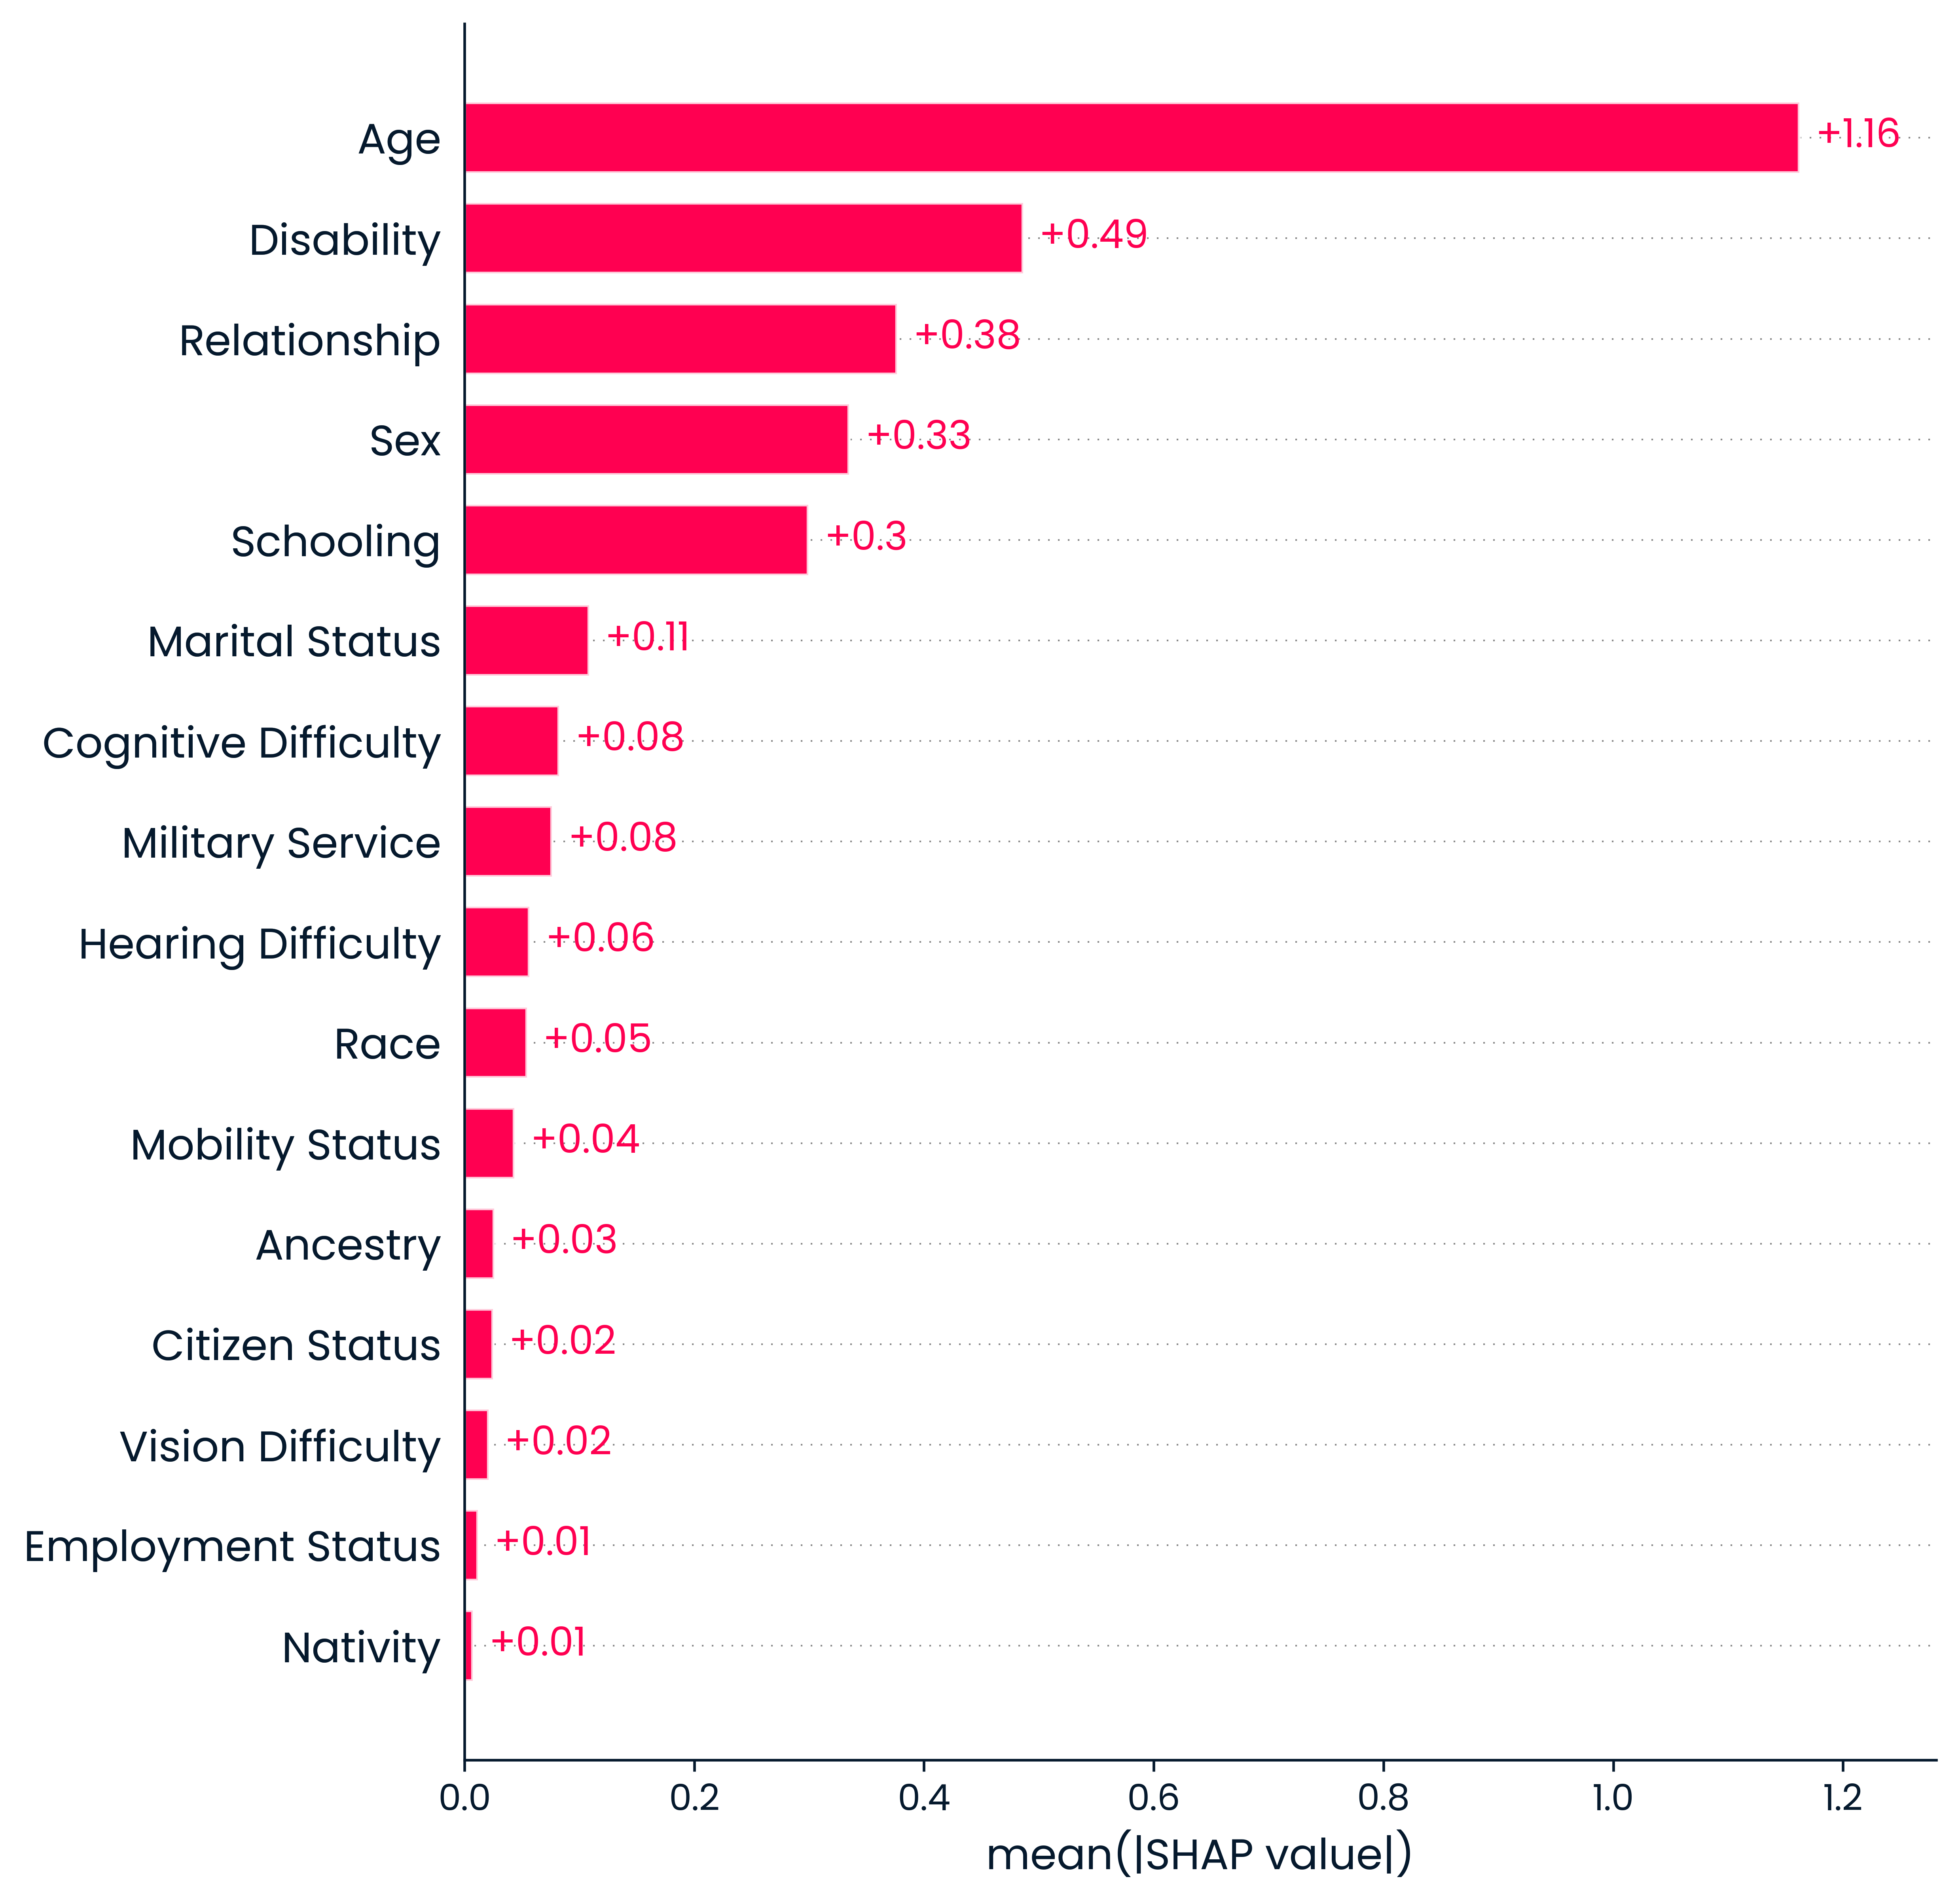

In [62]:
plt.figure(figsize=(8, 8), 
           dpi=300)

shap.plots.bar(cb_shap, 
               max_display=17, 
               show=False)

plt.show()

**Bar chart with feature importance (split by cohorts)**

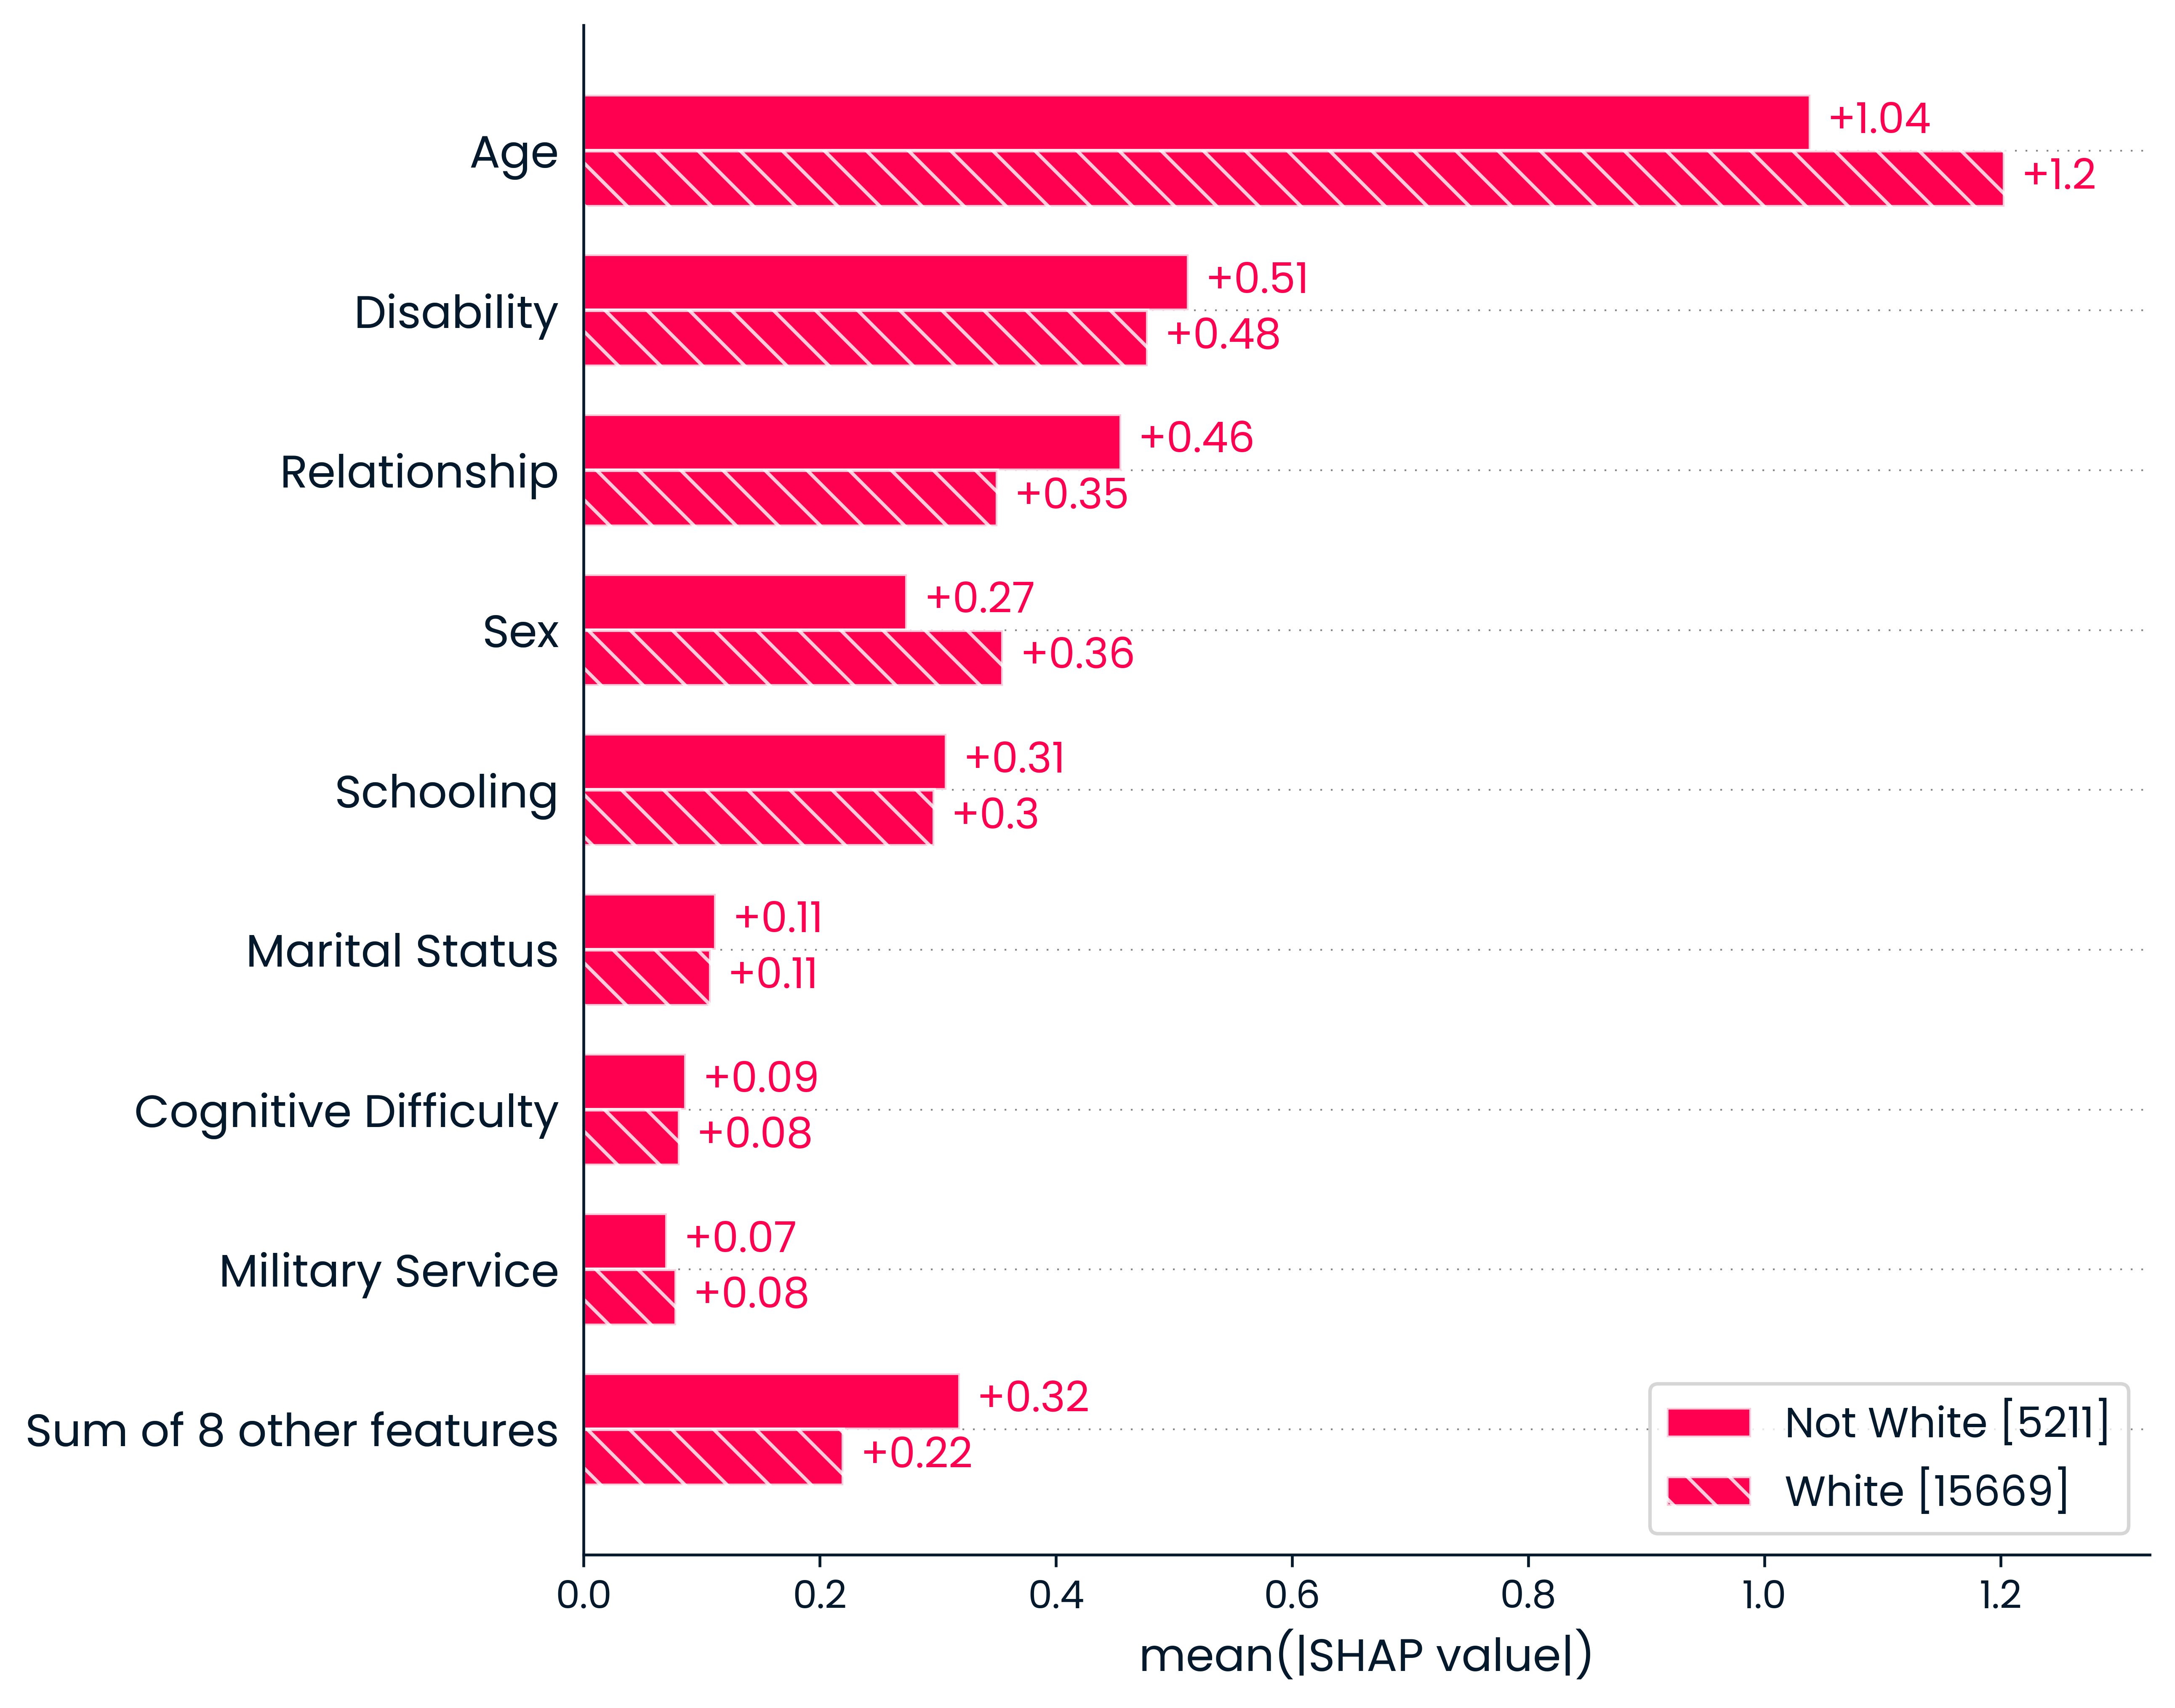

In [63]:
plt.figure(figsize=(8, 8), 
           dpi=300)

race_cohort = np.where(X_test.Race == 1,
                       "White", 
                       "Not White")

shap.plots.bar(cb_shap \
               .cohorts(race_cohort) \
               .abs.mean(0), max_display=9, \
               show=False)

plt.show()

**Beeswarm plot**

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


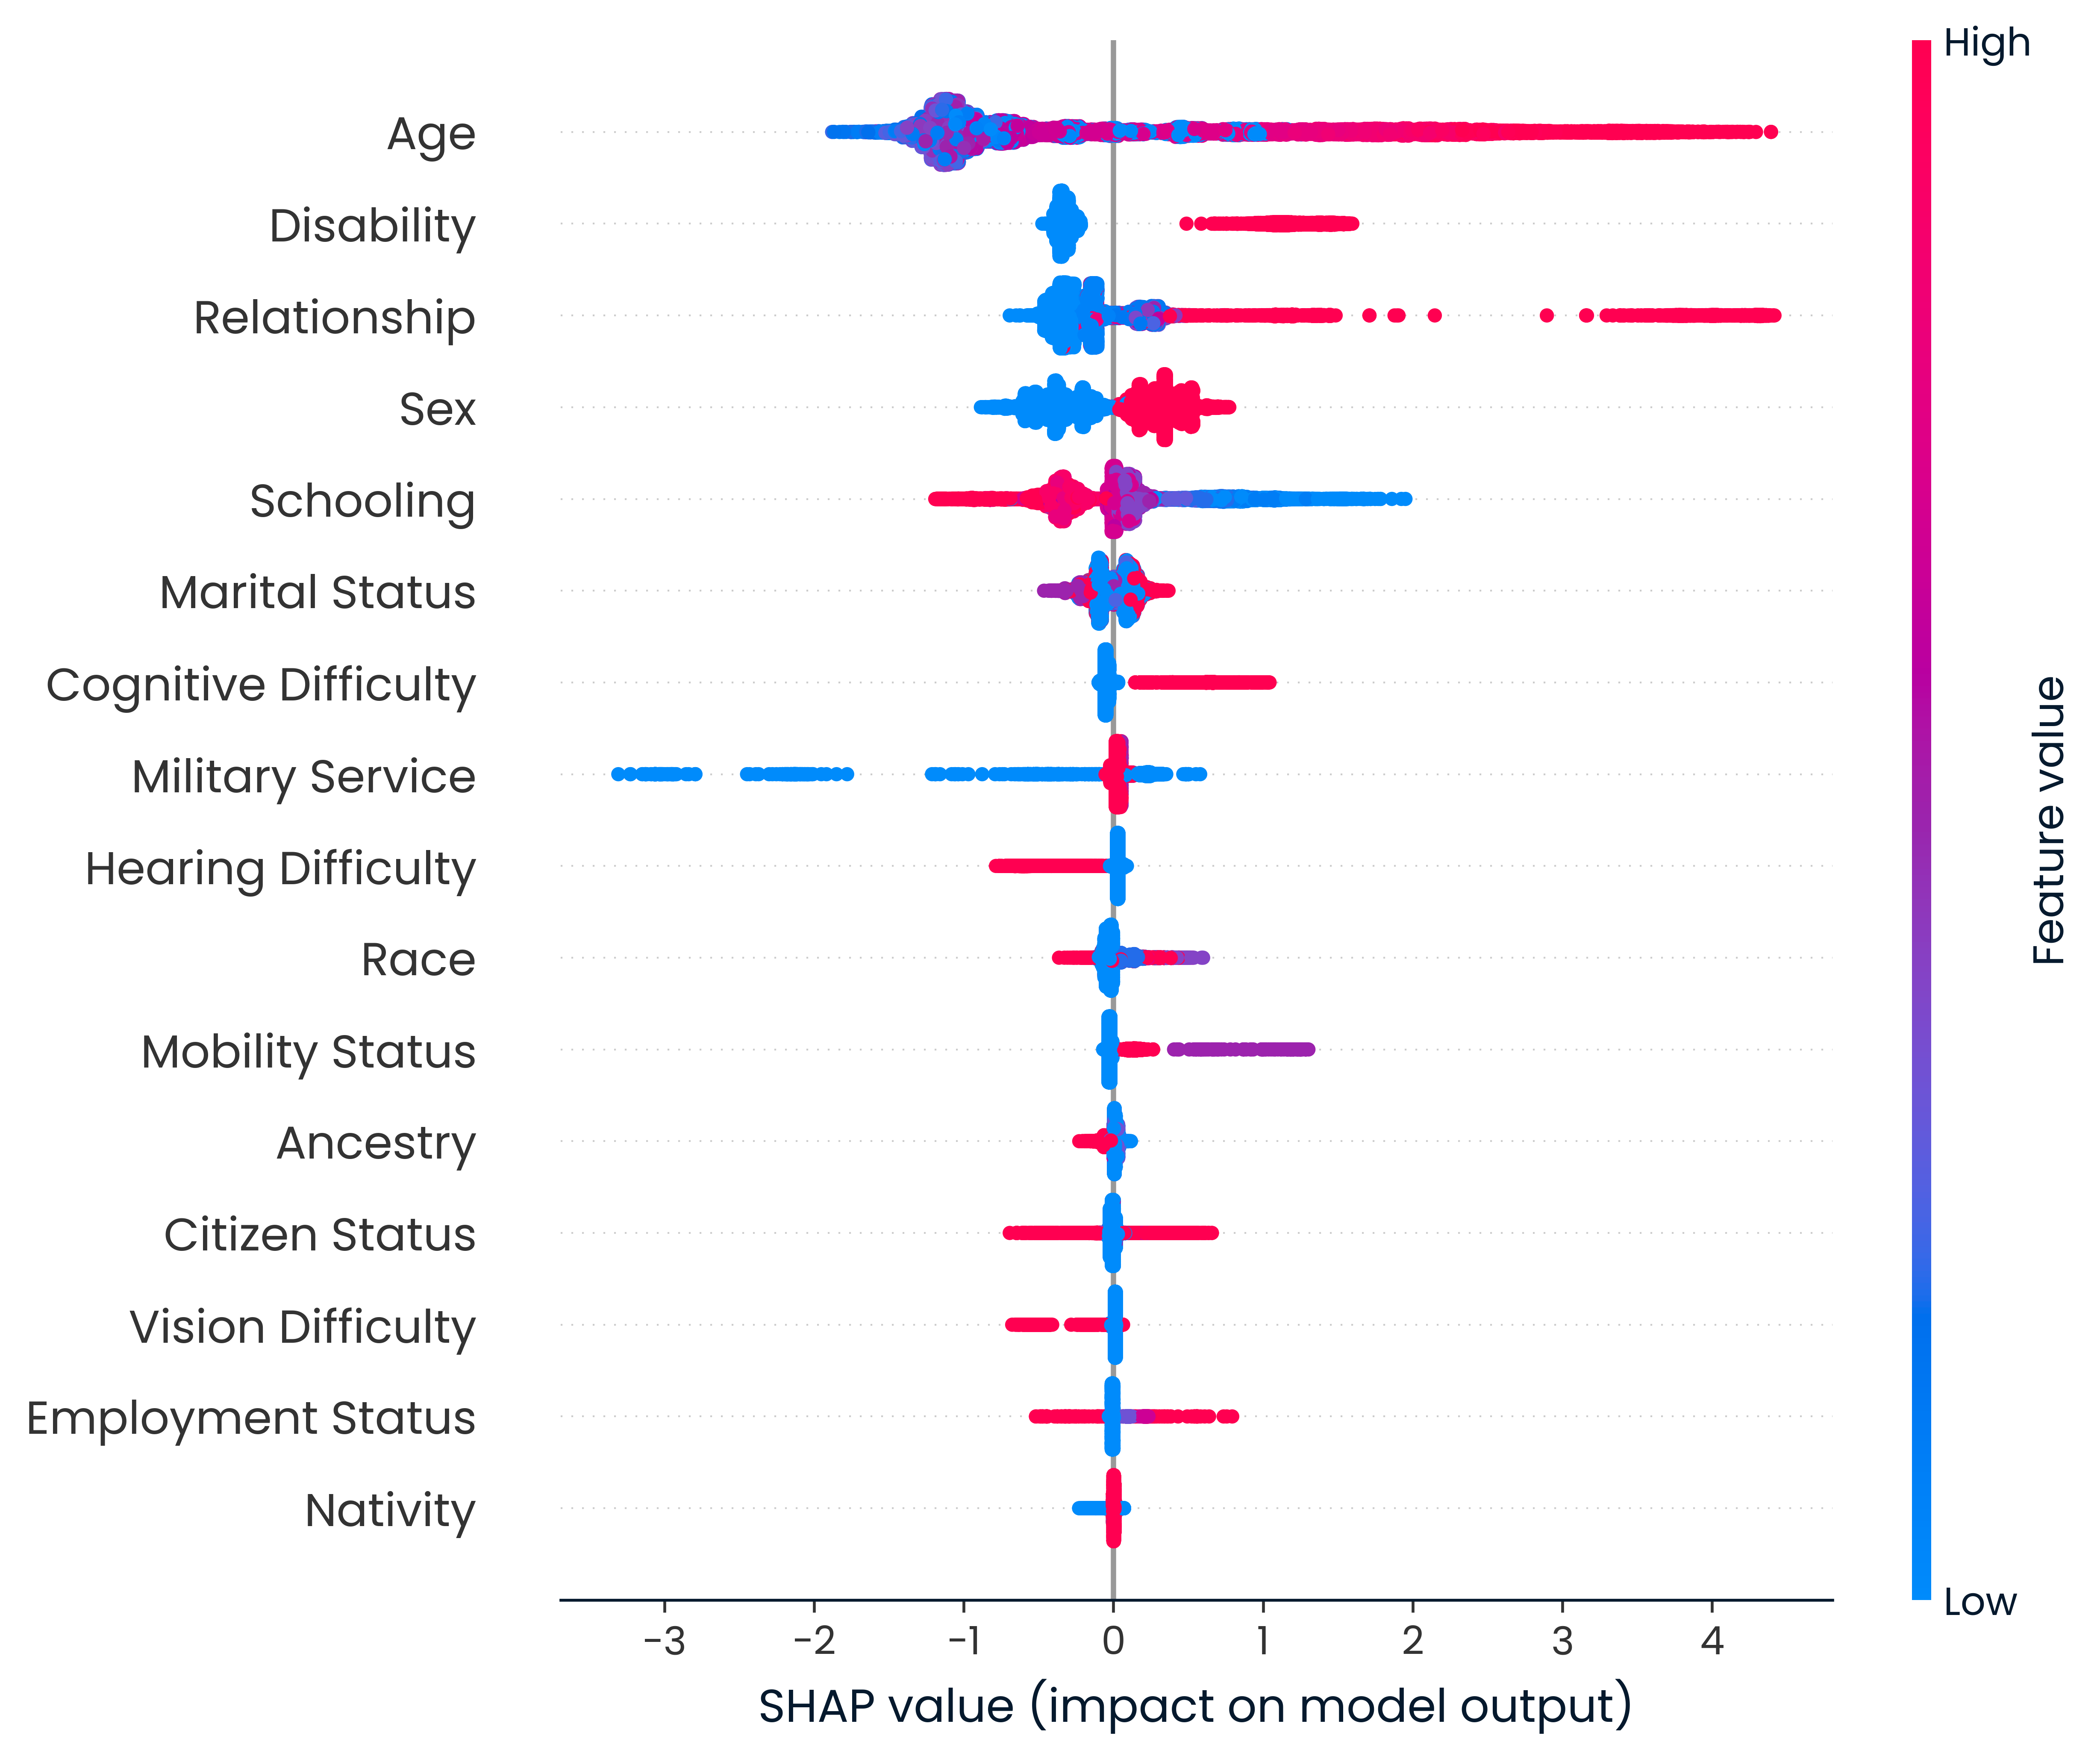

In [64]:
plt.figure(figsize=(8, 8), 
           dpi=300)

shap.plots.beeswarm(cb_shap, 
                    max_display=17, 
                    show=False)

plt.show()

This SHAP beeswarm plot provides a global explanation of how features influence the CatBoost model’s predictions across all test samples. Each point represents an individual observation, where the horizontal position (SHAP value) indicates how much that feature increases or decreases the model output, and the color reflects the feature value (blue = low, red = high). Features are ordered by overall importance, with Age showing the strongest and widest impact on predictions. The spread along the x-axis reveals both the magnitude and variability of each feature’s effect, while the color patterns help identify directional relationships—for example, higher values of Age tend to push predictions upward, whereas lower values often reduce the predicted outcome. Features clustered tightly around zero, such as Nativity or Employment Status, have limited influence on the model. Overall, this visualization highlights not only which features matter most, but also how different values of those features affect predictions in practice.

#### 5.2.2) Most important Feature Explanations

Partial dependence plots show the marginal effect a feature has on the predicted outcome throughout all the potential values of said feature.

What we are asking here, is what is the average predicted outcome for each observation should we change it's `Age`

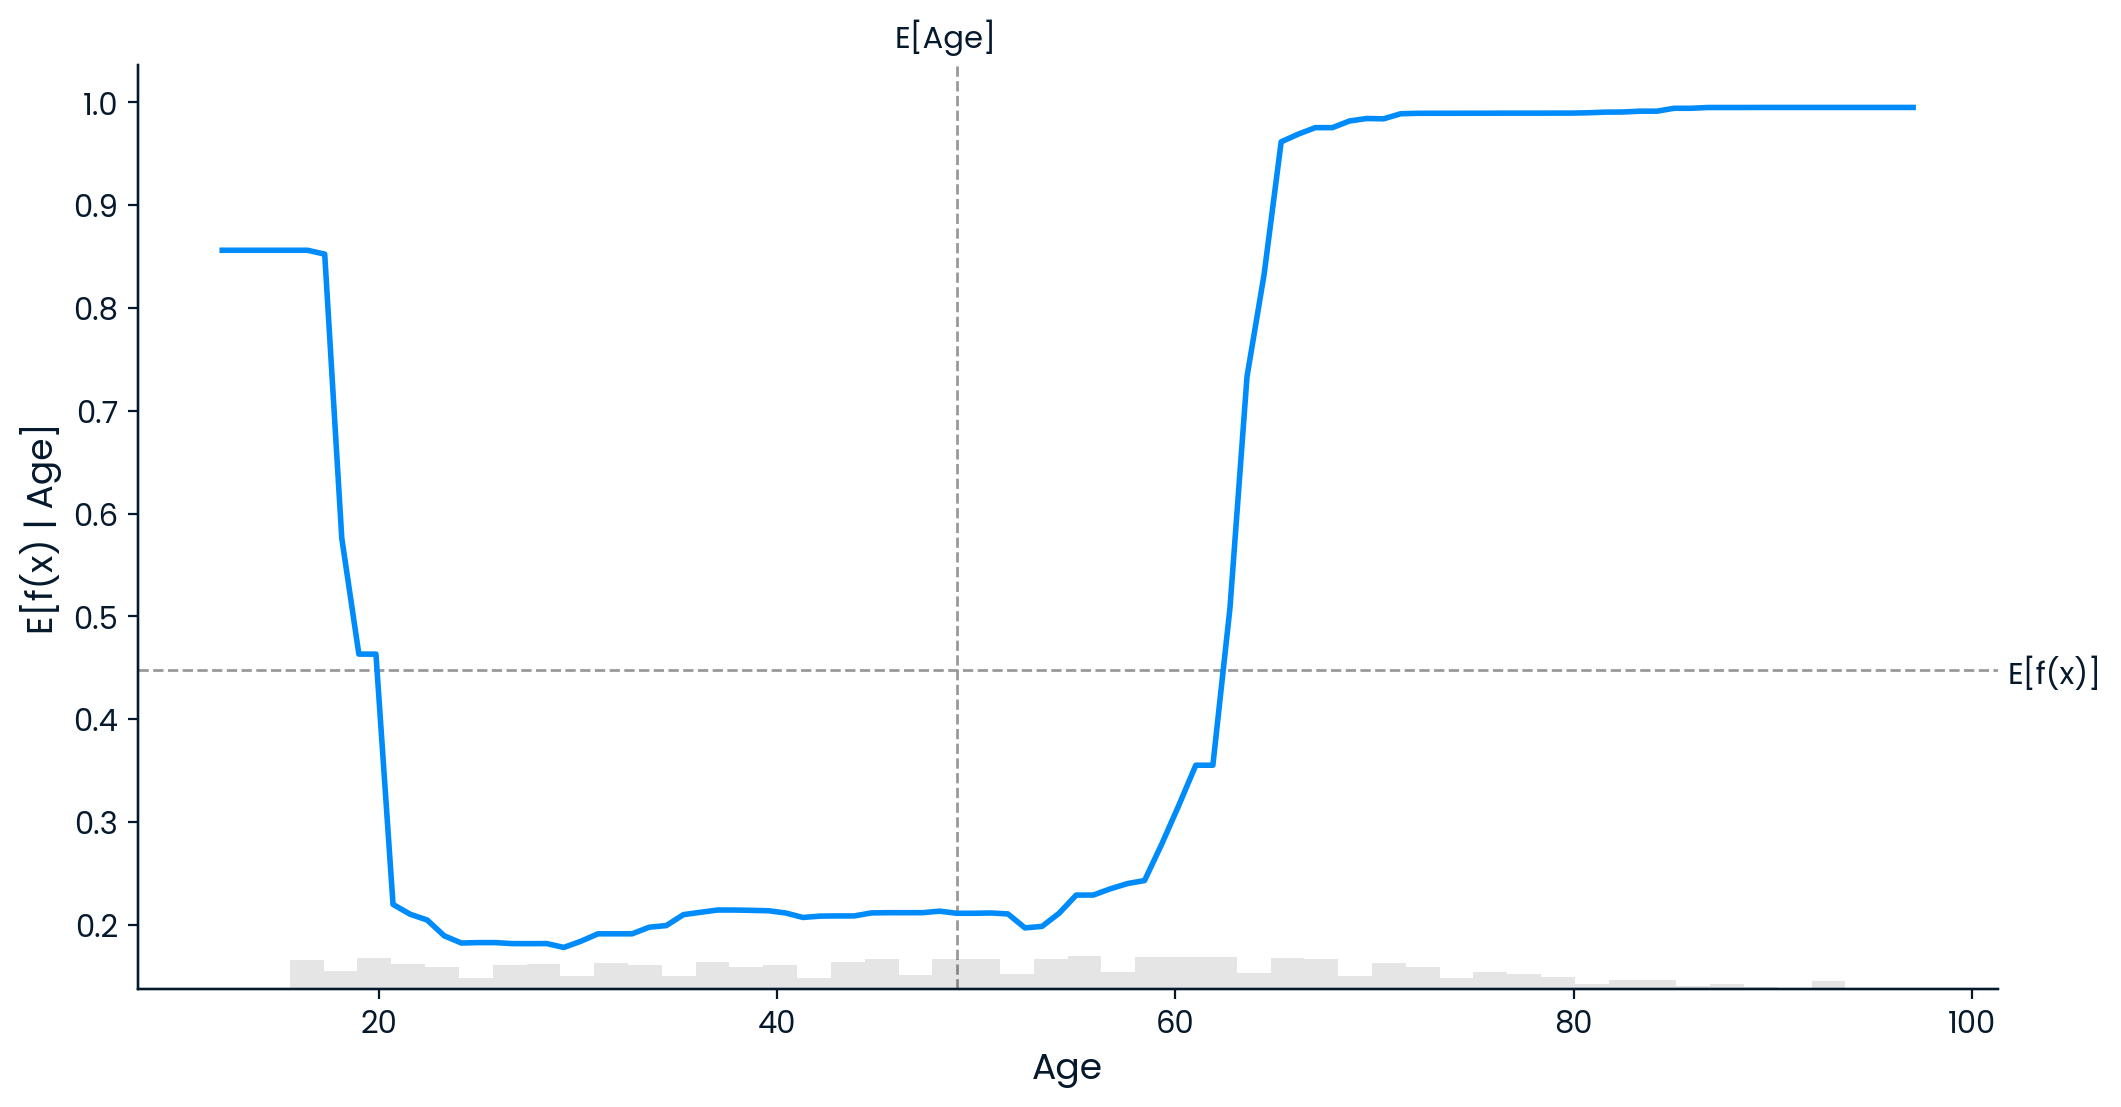

In [65]:
plt.rcParams["figure.figsize"] = (12,6)

shap.plots.partial_dependence("Age", 
                              cb_mdl.predict, 
                              X_test,
                              ice=False, 
                              model_expected_value=True, 
                              feature_expected_value=True,
                              show=False)
plt.show()

As you can see in the previous plot, when the age is under 21 and over 64 the probability of "Not Working" is above average and shoots up under and above these ages. This is to be expected.

#### 5.2.3) Feature Interactions

In [67]:
%%time
clustering = shap.utils.hclust(X, y)

17it [00:55,  3.94s/it]                        

CPU times: user 1min 51s, sys: 0 ns, total: 1min 51s
Wall time: 58.1 s


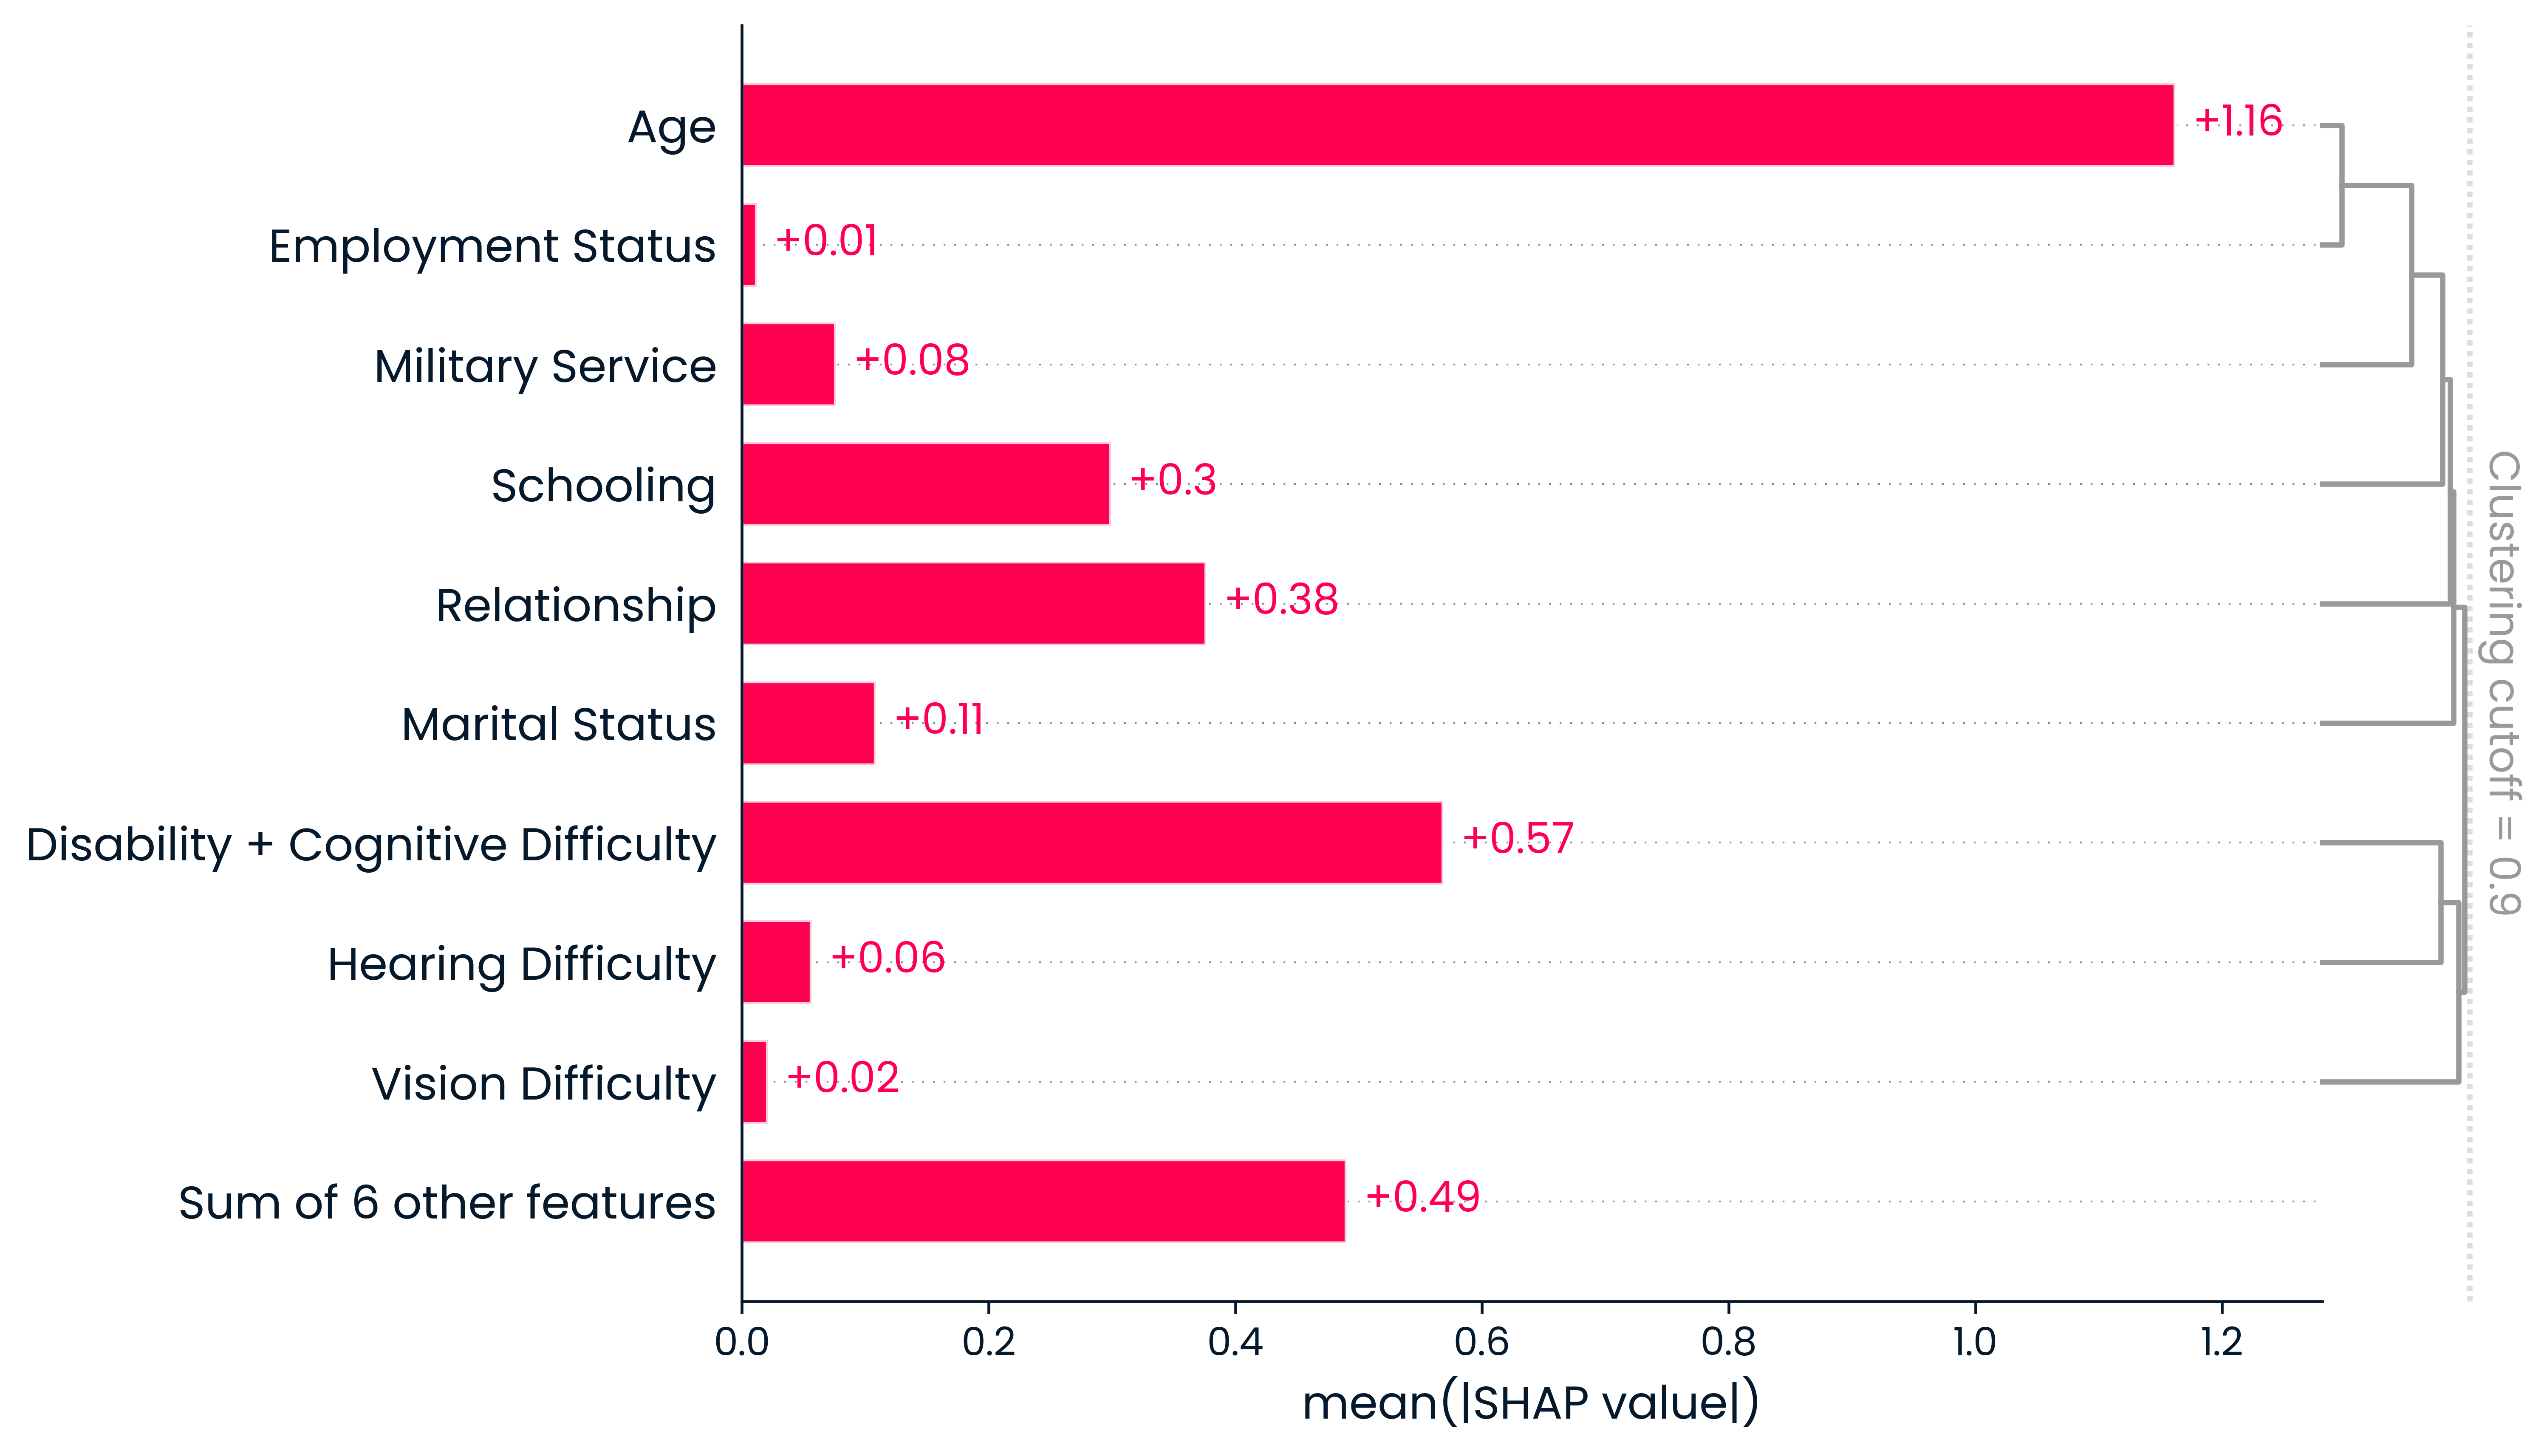

In [68]:
plt.figure(figsize=(12, 12), 
           dpi=300)

shap.plots.bar(cb_shap, 
               clustering = clustering, 
               clustering_cutoff = 0.9,
               show = False)
plt.show()

This plot extends the global SHAP feature importance analysis by grouping features based on how similarly they interact with the model’s predictions. Using hierarchical clustering on SHAP values, features that tend to influence the model in similar ways across observations are grouped together. The bars still represent the mean absolute SHAP value (overall importance), but the dendrogram on the right shows which features behave similarly rather than independently. For example, variables related to disability and cognitive limitations form a cluster, indicating that the model often uses them together to explain predictions. Age appears as a dominant and largely independent driver, while other socio-demographic features (such as relationship status, schooling, and marital status) cluster together, suggesting shared interaction patterns. This view helps distinguish truly independent drivers from groups of features whose effects are correlated or jointly learned by the model, providing deeper insight beyond simple feature ranking.